In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lib.model import build_model, FACEBOOK_2009_0, ENERGY_MODEL_WIERMAN
from lib.utils import summarize_distribution, plot_cdf

In [3]:
import logging

FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
logging.basicConfig(format=FORMAT)
logging.getLogger().setLevel(logging.INFO)

In [4]:
TIME_SLOT_LENGTH = 10 * 60
NORMALIZED_SWITCHING_COST = 1
REVENUE_LOSS = 0.1

# Model

In [5]:
model = build_model(
  FACEBOOK_2009_0,
  ENERGY_MODEL_WIERMAN,
  TIME_SLOT_LENGTH,
  NORMALIZED_SWITCHING_COST,
  REVENUE_LOSS,
)

# Inputs

In [6]:
inp = [[1], [5], [10], [3], [1], [10], [10], [3]]
online_inp = [[[[1]]], [[[5]]], [[[10]]], [[[3]]], [[[1]]], [[[10]]], [[[10]]], [[[3]]]]

# Execute

## Offline

In [7]:
from lib.offline import evaluate_1d

opt, iopt, _, _ = evaluate_1d(model, inp)

INFO soco.bindings.data_center.offline 2021-07-28 18:16:03,094 offline.rs:83 Graph Search
INFO soco.streaming.offline 2021-07-28 18:16:03,095 offline.rs:40 Generated a problem instance: SimplifiedSmoothedConvexOptimization { d: 1, t_end: 8, bounds: [600], switching_cost: [6.0] }
INFO soco.streaming.offline 2021-07-28 18:16:03,096 offline.rs:42 Simulating until time slot 8.
INFO soco.streaming.offline 2021-07-28 18:16:06,394 offline.rs:49 Completed with Cost { cost: 21076.0, output: Success(DataCenterModelOutputSuccess { energy_cost: 18000.0, revenue_loss: 2998.0, assignments: [[[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]]] }) } and Schedule([Config([1]), Config([3]), Config([7]), Config([2]), Config([1]), Config([7]), Config([7]), Config([2])])
INFO soco.bindings.data_center.offline 2021-07-28 18:16:06,396 offline.rs:130 Convex Program
INFO soco.streaming.offline 2021-07-28 18:16:06,397 offline.rs:40 Generated a problem instance: SmoothedConvexOptimization { d: 1, t_end: 8, bounds: [(

In [8]:
from lib.offline import evaluate_static

opts, iopts, _, _ = evaluate_static(model, inp)

INFO soco.bindings.data_center.offline 2021-07-28 18:16:06,673 offline.rs:130 Convex Program
INFO soco.streaming.offline 2021-07-28 18:16:06,675 offline.rs:40 Generated a problem instance: SmoothedConvexOptimization { d: 1, t_end: 8, bounds: [(0.0, 600.0)] }
INFO soco.streaming.offline 2021-07-28 18:16:06,677 offline.rs:42 Simulating until time slot 8.
INFO soco.streaming.offline 2021-07-28 18:16:09,610 offline.rs:49 Completed with Cost { cost: 29552.038022393408, output: Success(DataCenterModelOutputSuccess { energy_cost: 26751.3228, revenue_loss: 2755.443026393409, assignments: [[[]], [[]], [[]], [[]], [[]], [[]], [[]], [[]]] }) } and Schedule([Config([0.7427349999999999]), Config([3.392366]), Config([5.938256]), Config([5.938243]), Config([5.938254]), Config([7.544988]), Config([7.545343]), Config([7.5453529999999995])])
INFO soco.bindings.data_center.offline 2021-07-28 18:16:09,612 offline.rs:147 Static Integral
INFO soco.streaming.offline 2021-07-28 18:16:09,613 offline.rs:40 Gene

### Approximation algorithm

In [9]:
# from lib.utils import plot
# import numpy as np
# import matplotlib.pyplot as plt
# from lib.offline import evaluate_approx_graph_search

# # plot(np.array([1,2,3,4,5]), np.array([1,2,3,4,5]), 'x axis', 'y axis', 'test')
# # plt.show()

# x, y, opt = evaluate_approx_graph_search(model, inp)
# plt.axhline(y=opt, color='r', linestyle='-')
# plot(x, y, 'gamma', 'cost', 'approx_graph_search')
# plt.show()

## Online

In [11]:
from lib.online import evaluate_randomized_randomly_biased_greedy

initial_alg, alg, initial_ialg, ialg, energy_cost, revenue_loss, switching_cost, initial_runtime, runtimes = evaluate_randomized_randomly_biased_greedy(model, [], online_inp)

INFO soco.streaming.online 2021-07-28 18:16:30,930 online.rs:114 Generated a problem instance: Online { p: SimplifiedSmoothedConvexOptimization { d: 1, t_end: 0, bounds: [600], switching_cost: [6.0] }, w: 0 }
INFO soco.streaming.online 2021-07-28 18:16:30,932 online.rs:116 Simulating until time slot 0.
INFO soco.streaming.online 2021-07-28 18:16:30,938 online.rs:162 [server] Running on 127.0.0.1:3449.
  0%|          | 0/8 [00:00<?, ?it/s]INFO soco.streaming.online 2021-07-28 18:16:30,946 online.rs:169 [server] Connection established!
INFO soco.streaming.online 2021-07-28 18:16:30,947 online.rs:263 [client] Connected to 127.0.0.1:3449.
INFO soco.streaming.online 2021-07-28 18:16:30,949 online.rs:268 [client] Sent: DataCenterOnlineInput { loads: [PredictedLoadProfile([[1.0]])] }
INFO soco.streaming.online 2021-07-28 18:16:30,951 online.rs:194 [server] Received: DataCenterOnlineInput { loads: [PredictedLoadProfile([[1.0]])] }
INFO soco.model.data_center.model 2021-07-28 18:16:30,952 model

In [12]:
opt, iopt, opts, iopts, alg, ialg, energy_cost, revenue_loss, switching_cost

(1877203.252998,
 21076.0,
 29552.038022393408,
 32953.142857142855,
 3182256.0,
 3182256.0,
 3175200.0,
 0.0,
 7056.0)

## Evaluation

### Competitive Ratio

In [13]:
cr = alg / opt
icr = ialg / iopt
cr, icr

(1.6952112111023443, 150.98956158663884)

### Competitive Difference

In [14]:
cd = alg - opt
icd = ialg - iopt
cd, icd

(1305052.747002, 3161180.0)

### Regret

In [15]:
regret = alg - opts
iregret = ialg - iopts
regret, iregret

(3152703.9619776066, 3149302.8571428573)

### Cost Change

Regret relative to overall cost.

In [16]:
rel_regret = regret / opts
rel_iregret = iregret / iopts
rel_regret, rel_iregret

(106.6831316198432, 95.56911978913783)

Competitive difference relative to overall cost.

In [17]:
rel_cd = cd / opt
rel_icd = icd / iopt
rel_cd, rel_icd

(0.6952112111023443, 149.98956158663884)

### Fractional vs Integral

In [18]:
opt_vs_iopt = iopt / opt
opts_vs_iopts = iopts / opts
alg_vs_ialg = ialg / alg
opt_vs_iopt, opts_vs_iopts, alg_vs_ialg

(0.011227340441873, 1.1150886728073448, 1.0)

### Runtime

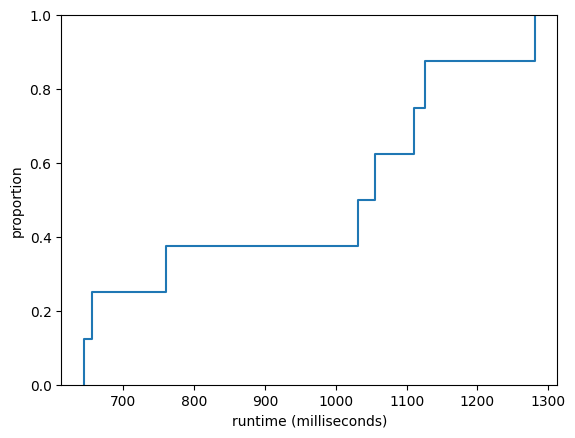

In [19]:
runtimes_np = np.array(runtimes)
plot_cdf(runtimes_np, 'runtime (milliseconds)', 'online_runtime')
plt.show()
summary = summarize_distribution(runtimes_np)

### Model

Proportion of energy cost to delay cost

In [20]:
ec_vs_rl = energy_cost / revenue_loss if revenue_loss > 0 else np.Inf
hc_vs_sc = (energy_cost + revenue_loss) / switching_cost
ec_vs_rl, hc_vs_sc

(inf, 450.0)